I've still got issue with how I'm doing my projection of the matter distribution. I'm going to debug it here, and also implement kappa here as well. the best way to do that will be to make sure the projection integral mutltiplies by a flexible kernel weighting. 

$$ \kappa_{Born} = \frac{3 H_0^2 \Omega_m}{2 c^2} \int_0^{\chi_s} d\chi \frac{\chi}{a(\chi)} \left(1 - \frac{\chi}{\chi_s} \right) \delta(\chi_{\theta}, \chi) $$

In [22]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import healpy as hp
from os import path

In [23]:
directory = '/home/users/swmclau2/scratch/UatuLightconeTraining/Box000/'

In [24]:
reader = pd.read_csv(path.join(directory, 'uatu_lightcone.0'), delim_whitespace = True, chunksize = 500000)

In [25]:
N = 2048
n_bins = 12*N**2
healpix_hist = np.zeros((n_bins,))

In [26]:
from astropy import cosmology
def get_astropy_cosmo(directory, boxno):
    """
    Get the astropy cosmology according to the parameters of this box
    """
    with open(path.join(directory, 'input_params%03d.dat'%boxno), 'r') as f:
        for line in f:
            if line[0] == 'O':
                splitline = line.split(':')
                omega_m = float(splitline[-1])

            elif line[0] == 's':
                splitline = line.split(':')
                sigma_8 = float(splitline[-1])

                # don't use sigma_8, not sure it matters
    return cosmology.FlatLambdaCDM(H0 = 70, Om0 = omega_m, Ob0 = 0.022/(0.7**2) )


In [27]:
cosmo = get_astropy_cosmo(directory, 0)

In [28]:
from scipy.interpolate import interp1d
def ra_dec_z(x, cosmo):
    
    if len(x.shape) == 1:
        x = np.array([x])

    # calculate the observed redshift
    if cosmo is None:
        cosmo = cosmology.FlatLambdaCDM(H0=0.7, Om0=0.3)

    # remove h scaling from position so we can use the cosmo object
    x = x/cosmo.h

    # compute comoving distance from observer
    r = np.sqrt(x[:, 0]**2+x[:, 1]**2+x[:, 2]**2)

    # compute cosmological redshift and add contribution from perculiar velocity
    yy = np.arange(0, 1.0, 0.001)
    xx = cosmo.comoving_distance(yy).value
    f = interp1d(xx, yy, kind='cubic')
    redshift = f(r)

    # calculate spherical coordinates
    theta = np.arccos(x[:, 2]/r)
    phi = np.arctan2(x[:, 1], x[:, 0])
    ra = phi
    dec = theta - np.pi/2.0

    return ra, dec, redshift

In [29]:
def kappa_weighting(x,y, z, cosmo, redshift_s = 2):
    #print x.shape
    #print np.hstack([x,y,z]).shape
    _, _, redshift = ra_dec_z(np.hstack([x,y,z]), cosmo)
    comoving_dist = np.sqrt(x**2+y**2+z**2)
    comoving_dist_s = cosmo.comoving_distance(redshift_s).value
    return comoving_dist*(1+redshift)*(1-comoving_dist/comoving_dist_s)

In [30]:
kappa = True
for i, chunk in enumerate(reader):
    print i
    arr = chunk.values[:, :3]
    x,y,z = arr[:,0].astype(float), arr[:,1].astype(float), arr[:,2].astype(float)
    rad2 = x**2+y**2+z**2
    
    in_shell = rad2<=512**2
    
    if np.all(~in_shell):
        print 'skippin'
        continue
    
    x,y,z = x[in_shell], y[in_shell], z[in_shell]

    pix = hp.vec2pix(N, x, y, z)
    if kappa:
        weights = kappa_weighting(x,y,z, cosmo)
    else:
        weights = np.ones_like(pix)
    hmap, _ = np.histogram(pix, np.arange(n_bins+1), weights = weights ) #use weights here 
    healpix_hist+=hmap

0
skippin
1
skippin
2
skippin
3
skippin
4
skippin
5
skippin
6
skippin
7
skippin
8
skippin
9
skippin
10
skippin
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
25

In [31]:
np.savetxt('tmp_healpix_kappa.npy', healpix_hist)

In [32]:
#(size/2)/90*3.5
print 'Size required: ', 2*256*90/10

Size required:  4608


In [33]:
size = 4608
projector = hp.projector.GnomonicProj(xsize = size, reso = 1.0)

In [34]:
def get_vec2pix_func():
    
    def f(x,y,z):
        out =  hp.pixelfunc.vec2pix(N, x, y, z)
        return out
        
    return f

In [35]:
proj_map2 = projector.projmap(healpix_hist, get_vec2pix_func() )[size/2:, :size/2]

/share/software/user/open/py-jupyter/1.0.0_py27/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


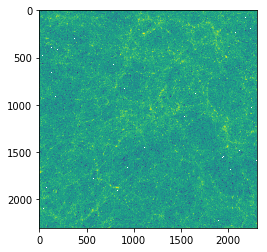

In [36]:
plt.imshow(np.log10(proj_map2))#, vmin=0, vmax = 2.5)

In [37]:
n_pixels = 256
n_per_map = proj_map2.shape[0]/n_pixels

In [38]:
x = np.zeros((n_per_map**2, n_pixels, n_pixels))

In [39]:
print x.shape

(81, 256, 256)


In [40]:
for i in xrange(n_per_map):
    for j in xrange(n_per_map):
        x[i*n_per_map+j] = np.log10(proj_map2[i*n_pixels:(i+1)*n_pixels, j*n_pixels:(j+1)*n_pixels])

/share/software/user/open/py-jupyter/1.0.0_py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


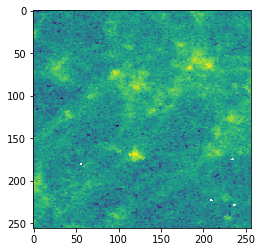

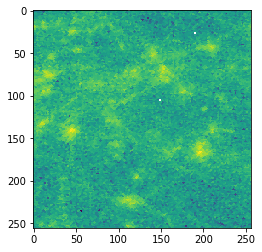

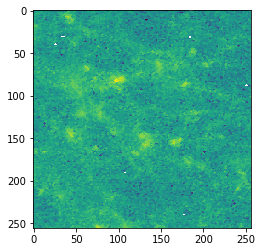

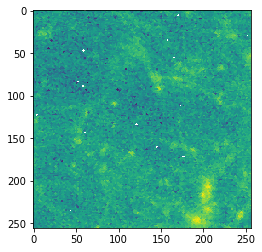

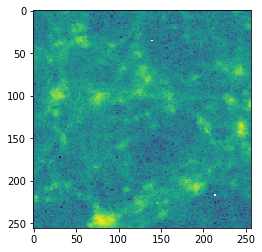

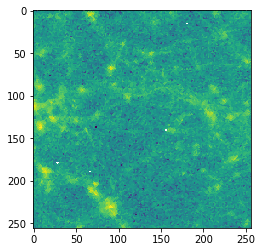

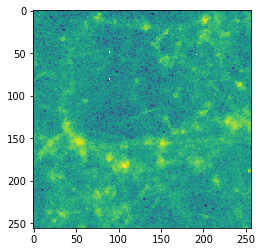

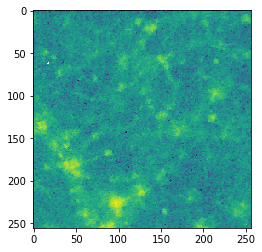

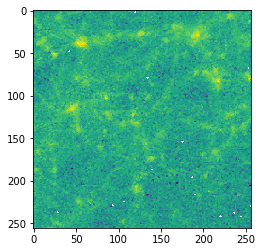

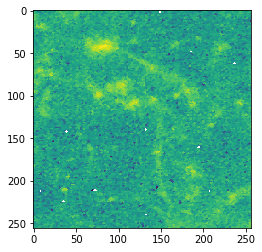

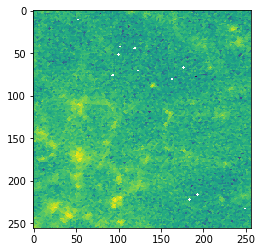

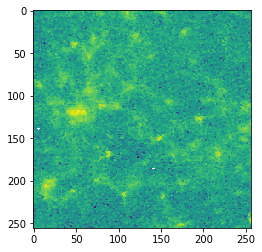

In [41]:
lim = 10
for idx, i in enumerate(x):
    #i[i<3] = 3
    plt.imshow(i)
    plt.show()
    if idx > lim:
        break

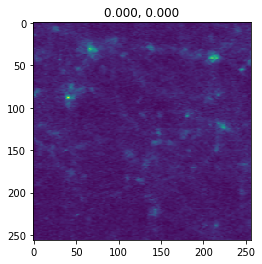

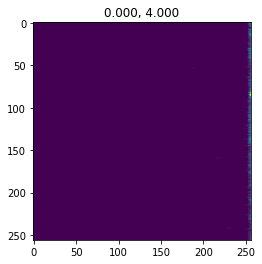

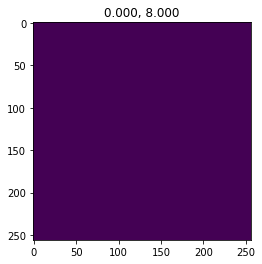

KeyboardInterrupt: 

In [18]:
size = 256
ang_size = 4
xx, yy = np.meshgrid( np.linspace(0,0+ang_size, size), np.linspace(0,0+ang_size,size))

for lon in xrange(0,90,ang_size):
    for lat in xrange(0,75,ang_size):
        _hp = rotate_map(healpix_hist, np.radians(lon), np.radians(lat) )
        interp_map = hp.pixelfunc.get_interp_val(_hp,xx,yy, lonlat=True)
        plt.imshow(interp_map.reshape((size,size)))
        plt.title('%.3f, %.3f'%(lon, lat))
        plt.show()

In [ ]:
for d in xrange(0,360,45):
    hp.cartview(np.log10(healpix_hist), rot = [0,0,d])#, lonra = [0, 90], latra = [0, 90])

In [ ]:
for d in xrange(0,360,45):
    hp.cartview(np.log10(healpix_hist), rot = [0,d,0])#, lonra = [0, 90], latra = [0, 90])

In [ ]:
hp.mollview(np.log10(healpix_hist), rot = [45,45,0])#, lonra = [0, 90], latra = [0, 90])

In [ ]:
hp.cartview(np.log10(healpix_hist), rot = [0,45,0])#, lonra = [0, 90], latra = [-45,45])

In [ ]:
for lon in xrange(0,90, 5):
    for lat in xrange(-45, 45, 5):
        hp.cartview(np.log10(healpix_hist), rot = [0,45,90], lonra = [lon,lon+5], latra = [lat, lat+5])
        plt.show()

In [10]:
def rotate_map(hmap, rot_theta, rot_phi):
    """
    Take hmap (a healpix map array) and return another healpix map array 
    which is ordered such that it has been rotated in (theta, phi) by the 
    amounts given.
    """
    nside = hp.npix2nside(len(hmap))

    # Get theta, phi for non-rotated map
    t,p = hp.pix2ang(nside, np.arange(hp.nside2npix(nside))) #theta, phi

    # Define a rotator
    r = hp.Rotator(deg=False, rot=[rot_phi,rot_theta])

    # Get theta, phi under rotated co-ordinates
    trot, prot = r(t,p)

    # Interpolate map onto these co-ordinates
    rot_map = hp.get_interp_val(hmap, trot, prot)

    return rot_map

In [ ]:
hp.cartview(np.log10(rotate_map(healpix_hist, 0, 0)))

In [ ]:
size = 10
for i in xrange(0,90,size):
    for j in xrange(0, 90, size):
        hp.cartview(healpix_hist+1, norm = 'log', lonra = [i, i+size], latra = [j, j+size])
        plt.show()

In [ ]:
fname = path.join(directory, 'proj_bias_hist_idx_000_box_000.npy')

In [ ]:
im_list = np.load(fname)
print im_list.shape

In [ ]:
fname2 = path.join(directory, 'full_proj_box_000.npy') #'full_bias_hist_idx_000_box_000.npy'

In [ ]:
particle_box = np.load(fname2)

In [ ]:
particle_box.shape

In [ ]:
np.max(particle_box), np.min(particle_box)

In [ ]:
img = plt.imshow(particle_box[:,:,0] - particle_box.min() + 1e-6, norm = LogNorm(vmin = 1e-6, vmax = particle_box.max()-particle_box.min()))
plt.colorbar(img)

In [ ]:
box_3d_fname = path.join(directory, 'full_particle_hist_000.npy')
box_3d = np.load(box_3d_fname)

In [ ]:
?? hp.vec2pix

In [ ]:
idxs = range(box_3d.shape[0])

In [ ]:
from itertools import product
all_idxs = np.array(list(product(idxs, repeat = 3)))

In [ ]:
all_idxs.shape

In [ ]:
N = 1024
# pass in the particles directly here. 
pix = hp.vec2pix(N, all_idxs[:, 0], all_idxs[:, 1], all_idxs[:,2])

In [ ]:
hmap, _ = np.histogram(pix, np.arange(12*N**2+1)) #use weights here 

In [ ]:
box_3d.shape

In [ ]:
img = plt.imshow( box_3d[:,:, 2]+1, norm = LogNorm(vmin = 1, vmax = 10000) )
plt.colorbar(img)
plt.show()

In [ ]:
from uatu.simulations import get_astropy_cosmo, convert_box_to_proj_density#, ra_dec_z#convert_box_to_proj_density
from itertools import product, izip

In [ ]:
def ra_dec_z(x, cosmo=None):
    if len(x.shape) == 1:
        x = np.array([x])

    # calculate the observed redshift
    if cosmo is None:
        cosmo = cosmology.FlatLambdaCDM(H0=0.7, Om0=0.3)

    # remove h scaling from position so we can use the cosmo object
    x = x/cosmo.h

    # compute comoving distance from observer
    r = np.sqrt(x[:, 0]**2+x[:, 1]**2+x[:, 2]**2)

    # compute cosmological redshift and add contribution from perculiar velocity
    yy = np.arange(0, 1.0, 0.001)
    xx = cosmo.comoving_distance(yy).value
    f = interp1d(xx, yy, kind='cubic')
    redshift = f(r)

    # calculate spherical coordinates
    theta = np.arccos(x[:, 2]/r)
    phi = np.arctan2(x[:, 1], x[:, 0])
    ra = phi
    dec = theta - np.pi/2.0

    return ra, dec, redshift

In [ ]:
import pandas as pd
from scipy.interpolate import interp1d

In [ ]:
import healpy

In [ ]:
4096*2

In [ ]:
def convert_box_to_proj_density(directory, boxno,box, Lbox = 512.0, nside = 4096, pixels_per_side = 8, n_z_bins = 4):
    # ang size image: size of each sub image in degrees
    # pixels_per_side: number of pixels per side in the sub images
    
    reader = pd.read_csv(path.join(directory, 'uatu_lightcone.0'), delim_whitespace = True, chunksize = 50000)

    cosmo = get_astropy_cosmo(directory, boxno)
    #establish min/max bounds

    test_coords = np.c_[np.array([0.0, 0.0, 0.0, 0.0, 512.0, 512.0, 512.0, 512.0]),\
                        np.array([0.0, 0.0, 512.0, 512.0, 0.0, 0.0, 512.0, 512.0]),\
                        np.array([0.0, 512.0, 0.0, 512.0, 0.0, 512.0, 0.0, 512.0])]

    ra,dec,z = ra_dec_z(test_coords, cosmo=cosmo)
    ra, dec = np.degrees(ra), np.degrees(dec)
    min_ra, max_ra = np.nanmin(ra), np.nanmax(ra)
    min_dec, max_dec = np.nanmin(dec), np.nanmax(dec)
    min_z, max_z = 0.0, np.nanmax(z)

    z_bin_size = max_z/n_z_bins
    
    npix = healpy.nside2npix(nside)
    hp_pixelization = np.zeros((npix,n_z_bins))

    
    for i, chunk in enumerate(reader):
        arr = chunk.values[:, :3]
        #x,y,z = arr[:,0].astype(float), arr[:,1].astype(float), arr[:,2].astype(float)
        coords = arr.astype(float)
        _, _, z = ra_dec_z(coords, cosmo=cosmo)
        pix_idxs = healpy.vec2pix(nside, coords[:,0], coords[:,1], coords[:,2]) #nest?

        z_idx = np.floor_divide(z, z_bin_size).astype(int)

        for pi, zi, density  in izip(pix_idxs, z_idx, np.nditer(box)):
            hp_pixelization[pi,  zi] += density #would like to avoid this for loop, hopefully numba helps

        
    return hp_pixelization
    # God has left this place
    # convert the histogram in a list of sub-voxels which will be hte input to the training set.
    x = np.array(np.split(proj_density, (max_ra - min_ra)/ang_size_image))
    pixel_list = np.vstack(np.split(x, (max_dec-min_dec)/ang_size_image, axis = 2))

    return pixel_list, proj_density
    #np.save(path.join(directory, 'part

In [ ]:
hp_pixelization = convert_box_to_proj_density(directory, 0, box = box_3d,\
                                    nside = 4096, pixels_per_side = 32,  n_z_bins = 4)

In [ ]:
map_rot = healpy.cartview(hp_pixelization[:,0]+1,lonra = [0, 90], latra = [0, 90],\
                          rot = [0,0, 0], return_projected_map=True, norm = 'log', cbar = False)

In [ ]:
size = 2

for a in xrange(0, 90, size):
    for b in xrange(0, 90, size):
        map_rot = healpy.cartview(hp_pixelization[:,0]+1,lonra = [a, a+size],latra = [b, b+size],\
                          rot = [a,b, 0], return_projected_map=True, norm = 'log', cbar = False)

In [ ]:
ra, dec

In [ ]:
proj_box_list , full_proj_box = convert_box_to_proj_density(directory, 0, box = box_3d,\
                                                            ang_size_image = 2, pixels_per_side = 32,  n_z_bins = 1)

In [ ]:
plt.scatter(ra, dec)

In [ ]:
plt.hist(ra)

In [ ]:
plt.hist(dec)

In [ ]:
cosmo = get_astropy_cosmo(directory, 0)

In [ ]:
test_coords = np.c_[np.array([0.0, 0.0,   0.0,   0.0,   512.0, 512.0, 512.0, 512.0]),\
                    np.array([0.0, 0.0,   512.0, 512.0, 0.0,   0.0,   512.0, 512.0]),\
                    np.array([0.0, 512.0, 0.0,   512.0, 0.0,   512.0, 0.0,   512.0])]

ra,dec,z = ra_dec_z(test_coords, cosmo=cosmo)
print np.degrees(ra), np.degrees(dec), z

In [ ]:
ra,dec,z = ra_dec_z(np.array([512.0, 512.0, 512.0]), cosmo=cosmo)
print np.degrees(ra), np.degrees(dec), z

In [ ]:
full_proj_box.shape, np.max(full_proj_box)

In [ ]:
img = plt.imshow( full_proj_box[:,:, 0]+1, norm = LogNorm(vmin = 1, vmax = 10000) )
plt.colorbar(img)
plt.show()